# 机器学习工程师纳米学位
## 模型评价与验证
## 项目 1: 预测波士顿房价


欢迎来到机器学习的预测波士顿房价项目！在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能来让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以**编程练习**开始的标题表示接下来的内容中有需要你必须实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以**TODO**标出。请仔细阅读所有的提示！

除了实现代码外，你还**必须**回答一些与项目和实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。你的项目将会根据你对问题的回答和撰写代码所实现的功能来进行评分。

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

---
## 第一步. 导入数据
在这个项目中，你将利用马萨诸塞州波士顿郊区的房屋信息数据训练和测试一个模型，并对模型的性能和预测能力进行测试。通过该数据训练后的好的模型可以被用来对房屋做特定预测---尤其是对房屋的价值。对于房地产经纪等人的日常工作来说，这样的预测模型被证明非常有价值。

此项目的数据集来自[UCI机器学习知识库(数据集已下线)](https://archive.ics.uci.edu/ml/datasets.html)。波士顿房屋这些数据于1978年开始统计，共506个数据点，涵盖了麻省波士顿不同郊区房屋14种特征的信息。本项目对原始数据集做了以下处理：
- 有16个`'MEDV'` 值为50.0的数据点被移除。 这很可能是由于这些数据点包含**遗失**或**看不到的值**。
- 有1个数据点的 `'RM'` 值为8.78. 这是一个异常值，已经被移除。
- 对于本项目，房屋的`'RM'`， `'LSTAT'`，`'PTRATIO'`以及`'MEDV'`特征是必要的，其余不相关特征已经被移除。
- `'MEDV'`特征的值已经过必要的数学转换，可以反映35年来市场的通货膨胀效应。

运行下面区域的代码以载入波士顿房屋数据集，以及一些此项目所需的 Python 库。如果成功返回数据集的大小，表示数据集已载入成功。

In [16]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


---
## 第二步. 分析数据
在项目的第一个部分，你会对波士顿房地产数据进行初步的观察并给出你的分析。通过对数据的探索来熟悉数据可以让你更好地理解和解释你的结果。

由于这个项目的最终目标是建立一个预测房屋价值的模型，我们需要将数据集分为**特征(features)**和**目标变量(target variable)**。
- **特征** `'RM'`， `'LSTAT'`，和 `'PTRATIO'`，给我们提供了每个数据点的数量相关的信息。
- **目标变量**：` 'MEDV'`，是我们希望预测的变量。

他们分别被存在 `features` 和 `prices` 两个变量名中。

### 编程练习 1：基础统计运算
你的第一个编程练习是计算有关波士顿房价的描述统计数据。我们已为你导入了 ` NumPy `，你需要使用这个库来执行必要的计算。这些统计数据对于分析模型的预测结果非常重要的。
在下面的代码中，你要做的是：
- 计算 `prices` 中的 `'MEDV'` 的最小值、最大值、均值、中值和标准差；
- 将运算结果储存在相应的变量中。

In [17]:
# TODO: Minimum price of the data
minimum_price = np.min(prices)

# TODO: Maximum price of the data
maximum_price = np.max(prices)

# TODO: Mean price of the data
mean_price = np.mean(prices)

# TODO: Median price of the data
median_price = np.median(prices)

# TODO: Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:.2f}".format(minimum_price)) 
print("Maximum price: ${:.2f}".format(maximum_price))
print("Mean price: ${:.2f}".format(mean_price))
print("Median price ${:.2f}".format(median_price))
print("Standard deviation of prices: ${:.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.00
Maximum price: $1024800.00
Mean price: $454342.94
Median price $438900.00
Standard deviation of prices: $165171.13


### 问题 1 - 特征观察

如前文所述，本项目中我们关注的是其中三个值:`'RM'`、`'LSTAT'` 和`'PTRATIO'`，对每一个数据点:
- `'RM'` 是该地区中每个房屋的平均房间数量；
- `'LSTAT'` 是指该地区有多少百分比的业主属于是低收入阶层（有工作但收入微薄）；
- `'PTRATIO'` 是该地区的中学和小学里，学生和老师的数目比（`学生/老师`）。

_凭直觉，上述三个特征中对每一个来说，你认为增大该特征的数值，`'MEDV'`的值会是**增大**还是**减小**呢？每一个答案都需要你给出理由。_

**提示：**你预期一个`'RM'` 值是6的房屋跟`'RM'` 值是7的房屋相比，价值更高还是更低呢？

### 问题 1 - 回答：
- 'RM'增加，'MEDV'会增加。因为房屋的房间数量越多，意味着房价要更贵。
- 'LSTAT'增加，'MEDV'会减小。因为更多低收入的人居住，意味着房价要更便宜。
- 'PTRATIO'增加，'MEDV'的变化不一定。学生和老师的数目比与房价的关系较弱。

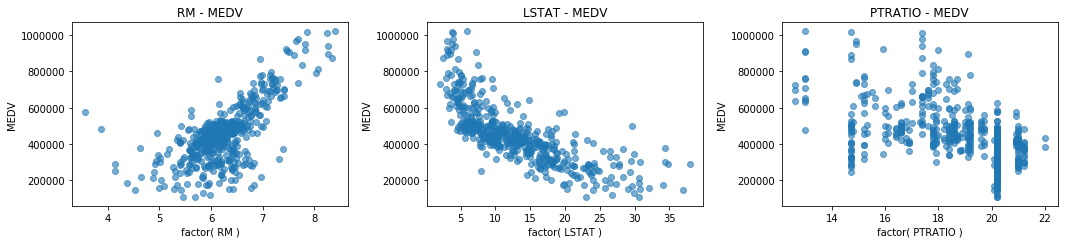

In [18]:
import matplotlib.pyplot as plt

dataset = ['RM', 'LSTAT', 'PTRATIO']
# 设定画图板尺寸
plt.figure(figsize=(15, 3.5))
for i, key in enumerate(dataset):
    # 设定子图，将每个子图输出到对应的位置,1行3列i+1依次排列
    plt.subplot(1,3,1+i)
    plt.title(key + ' - MEDV')
    plt.xlabel('factor( ' + key + ' )')
    plt.ylabel('MEDV')
    # 调整每隔子图之间的距离
    plt.tight_layout()
    plt.scatter(data[key], data['MEDV'], alpha = 0.6)

---
## 第三步. 建立模型
在项目的第三步中，你需要了解必要的工具和技巧来让你的模型进行预测。用这些工具和技巧对每一个模型的表现做精确的衡量可以极大地增强你预测的信心。

### 编程练习2：定义衡量标准
如果不能对模型的训练和测试的表现进行量化地评估，我们就很难衡量模型的好坏。通常我们会定义一些衡量标准，这些标准可以通过对某些误差或者拟合程度的计算来得到。在这个项目中，你将通过运算[决定系数](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$ 来量化模型的表现。模型的决定系数是回归分析中十分常用的统计信息，经常被当作衡量模型预测能力好坏的标准。

$R^2$ 的数值范围从0至1，表示**目标变量**的预测值和实际值之间的相关程度平方的百分比。一个模型的 $R^2$ 值为0还不如直接用**平均值**来预测效果好；而一个 $R^2$ 值为1的模型则可以对目标变量进行完美的预测。从0至1之间的数值，则表示该模型中目标变量中有百分之多少能够用**特征**来解释。模型也可能出现负值的 $R^2$，这种情况下模型所做预测有时会比直接计算目标变量的平均值差很多。

在下方代码的 `performance_metric` 函数中，你要实现：
- 使用 `sklearn.metrics` 中的 [`r2_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) 来计算 `y_true` 和 `y_predict` 的 $R^2$ 值，作为对其表现的评判。
- 将他们的表现评分储存到 `score` 变量中。

In [19]:
# TODO: Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### 问题 2 - 拟合程度

假设一个数据集有五个数据且一个模型做出下列目标变量的预测：

| 真实数值 | 预测数值 |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |
*你觉得这个模型已成功地描述了目标变量的变化吗？如果成功，请解释为什么，如果没有，也请给出原因。*  

**提示1**：运行下方的代码，使用 `performance_metric` 函数来计算 `y_true` 和 `y_predict` 的决定系数。

**提示2**：$R^2$ 分数是指可以从自变量中预测的因变量的方差比例。 换一种说法：

* $R^2$ 为0意味着因变量不能从自变量预测。
* $R^2$ 为1意味着可以从自变量预测因变量。
* $R^2$ 在0到1之间表示因变量可预测的程度。
* $R^2$ 为0.40意味着 Y 中40％的方差可以从 X 预测。

In [20]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


### 问题 2 - 回答:
R^2=0.923 接近于1，说明模型成功地描述了目标变量的变化

### 编程练习 3: 数据分割与重排
接下来，你需要把波士顿房屋数据集分成训练和测试两个子集。通常在这个过程中，数据也会被重排列，以消除数据集中由于顺序而产生的偏差。
在下面的代码中，你需要

* 使用 `sklearn.model_selection` 中的 `train_test_split`， 将 `features` 和 `prices` 的数据都分成用于训练的数据子集和用于测试的数据子集。
  - 分割比例为：80%的数据用于训练，20%用于测试；
  - 选定一个数值以设定 `train_test_split` 中的 `random_state` ，这会确保结果的一致性；
* 将分割后的训练集与测试集分配给 `X_train`, `X_test`, `y_train` 和 `y_test`。

In [21]:
# TODO: Import 'train_test_split'
from sklearn.model_selection import train_test_split

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=5)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### 问题 3 - 训练及测试
*将数据集按一定比例分为训练用的数据集和测试用的数据集对学习算法有什么好处？*

*如果用模型已经见过的数据，例如部分训练集数据进行测试，又有什么坏处？*

**提示：** 如果没有数据来对模型进行测试，会出现什么问题？

### 问题 3 - 回答:
- 测试集可以验证模型，并评估模型对未知数据的适应性。
- 对已知数据测试导致指标虚高，无法对模型的好坏做出准确评估。

---
## 第四步. 分析模型的表现
在项目的第四步，我们来看一下不同参数下，模型在训练集和验证集上的表现。这里，我们专注于一个特定的算法（带剪枝的决策树，但这并不是这个项目的重点），和这个算法的一个参数 `'max_depth'`。用全部训练集训练，选择不同`'max_depth'` 参数，观察这一参数的变化如何影响模型的表现。画出模型的表现来对于分析过程十分有益。

### 学习曲线
下方区域内的代码会输出四幅图像，它们是一个决策树模型在不同最大深度下的表现。每一条曲线都直观得显示了随着训练数据量的增加，模型学习曲线的在训练集评分和验证集评分的变化，评分使用决定系数 $R^2$。曲线的阴影区域代表的是该曲线的不确定性（用标准差衡量）。

运行下方区域中的代码，并利用输出的图形回答下面的问题。

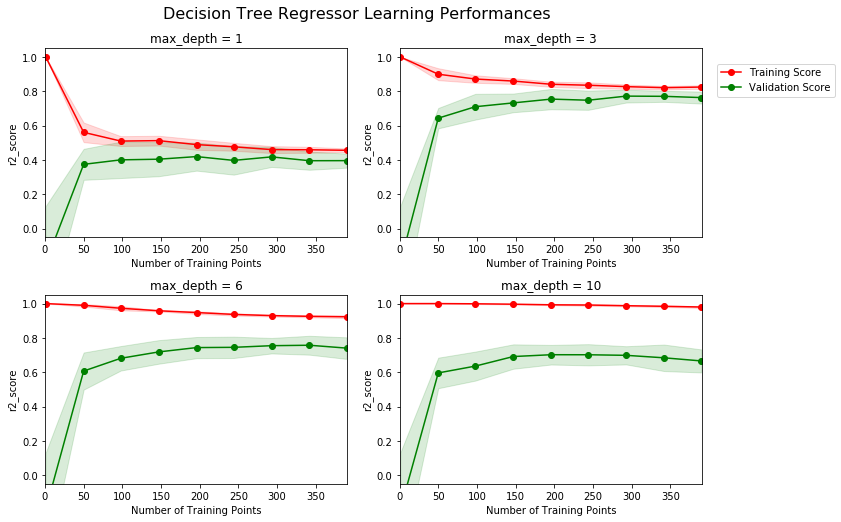

In [22]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### 问题 4 - 学习曲线
* 选择上述图像中的其中一个，并给出其最大深度。
* 随着训练数据量的增加，训练集曲线的评分有怎样的变化？验证集曲线呢？
* 如果有更多的训练数据，是否能有效提升模型的表现呢？

**提示：**学习曲线的评分是否最终会收敛到特定的值？一般来说，你拥有的数据越多，模型表现力越好。但是，如果你的训练和测试曲线以高于基准阈值的分数收敛，这是否有必要？基于训练和测试曲线已经收敛的前提下，思考添加更多训练点的优缺点。

### 问题 4 - 回答:
- 图 max_depth = 3
- 随着训练数据量的增加，训练集曲线的评分逐渐降低，验证集曲线的评分逐渐上升，最终都趋于平稳。
- 能。但数据越多，训练时间也越长。需要在精度和效率之间取得平衡。

### 复杂度曲线
下列代码内的区域会输出一幅图像，它展示了一个已经经过训练和验证的决策树模型在不同最大深度条件下的表现。这个图形将包含两条曲线，一个是训练集的变化，一个是验证集的变化。跟**学习曲线**相似，阴影区域代表该曲线的不确定性，模型训练和测试部分的评分都用的 `performance_metric` 函数。

**运行下方区域中的代码，并利用输出的图形并回答下面的问题5与问题6。**

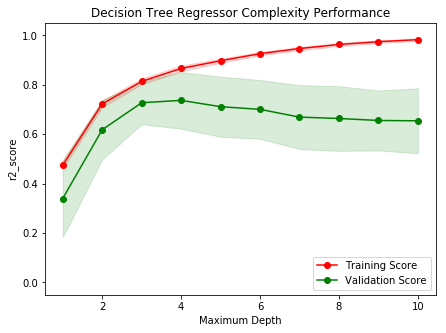

In [23]:
vs.ModelComplexity(X_train, y_train)

### 问题 5 - 偏差（bias）与方差（variance）之间的权衡取舍
* 当模型以最大深度 1训练时，模型的预测是出现很大的偏差还是出现了很大的方差？
* 当模型以最大深度10训练时，情形又如何呢？
* 图形中的哪些特征能够支持你的结论？
  
**提示：** 高偏差表示欠拟合（模型过于简单），而高方差表示过拟合（模型过于复杂，以至于无法泛化）。考虑哪种模型（深度1或10）对应着上述的情况，并权衡偏差与方差。

### 问题 5 - 回答:
- 很大的偏差。训练集和验证集的得分接近，且都较低。
- 很大的方差。训练集和验证集的得分差距较大，训练集的得分高，验证集的得分低。

### 问题 6- 最优模型的猜测
* 结合问题 5 中的图，你认为最大深度是多少的模型能够最好地对未见过的数据进行预测？
* 你得出这个答案的依据是什么？

**提示**：查看问题5上方的图表，并查看模型在不同 `depth`下的验证分数。随着深度的增加模型的表现力会变得更好吗？我们在什么情况下获得最佳验证分数而不会使我们的模型过度复杂？请记住，奥卡姆剃刀：“在竞争性假设中，应该选择假设最少的那一个。”

### 问题 6 - 回答:
- 4
- 训练集和验证集的得分接近，且都较高

---
## 第五步. 评估模型的表现
在项目的最后一节中，你将构建一个模型，并使用 `fit_model` 中的优化模型去预测客户特征集。

### 问题 7- 网格搜索（Grid Search）
* 什么是网格搜索法？
* 如何用它来优化模型？

**提示**：在解释网格搜索算法时，首先要理解我们为什么使用网格搜索算法，以及我们使用它的最终目的是什么。为了使你的回答更具有说服力，你还可以给出一个模型中可以使用此方法进行优化参数的示例。

### 问题 7 - 回答:
- 网格搜索（Grid Search）是一种通过遍历给定的参数组合来优化模型表现的方法，通过交叉验证（cross-validation）确定最佳效果参数。
- 网格搜索（Grid Search）只是在将参数组合好了，将数据输入到模型中，然后评估模型的准确性。

### 问题 8 - 交叉验证
- 什么是K折交叉验证法（k-fold cross-validation）？
- [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 是如何结合交叉验证来完成对最佳参数组合的选择的？
- [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 中的`'cv_results_'`属性能告诉我们什么？
- 网格搜索为什么要使用K折交叉验证？K折交叉验证能够避免什么问题？

**提示**：在解释k-fold交叉验证时，一定要理解'k'是什么，和数据集是如何分成不同的部分来进行训练和测试的，以及基于'k'值运行的次数。
在考虑k-fold交叉验证如何帮助网格搜索时，你可以使用特定的数据子集来进行训练与测试有什么缺点，以及K折交叉验证是如何帮助缓解这个问题。

### 问题 8 - 回答：
- k 折交叉验证法即将数据集分成 k 个子集，每个子集均做一次测试集，其余的作为训练集。如此交叉验证重复 k 次，每次选择一个子集作为测试集，并将 k 次的平均交叉验证识别率作为结果。
- GridSearchCV 传入交叉验证 cv 参数，设置为 k 折交叉验证。对训练集训练完成后调用 bestparams 变量，打印出训练的最佳参数组合。
- 'cvresults' 保存不同超参数的组合方式，其计算结果以字典的形式保存。
- 网格搜索算法的本质其实就是穷举，穷举所有的提供的超参数的组合情况，并验证模型基于每组参数的表现以达到挑选最优参数组合的目的。网格搜索时使用 k 折交叉验证的优点在于所有的样本都被作为了训练集和测试集，每个样本都被验证了一次，使得模型泛化能力达到最优。

### 编程练习 4：拟合模型
在这个练习中，你将需要将所学到的内容整合，使用**决策树算法**训练一个模型。为了得出的是一个最优模型，你需要使用网格搜索法训练模型，以找到最佳的 `'max_depth'` 参数。你可以把`'max_depth'` 参数理解为决策树算法在做出预测前，允许其对数据提出问题的数量。决策树是**监督学习算法**中的一种。

另外，你会发现在实现的过程中是使用`ShuffleSplit()`作为交叉验证的另一种形式（参见'cv_sets'变量）。虽然它不是你在问题8中描述的K-fold交叉验证方法，但它同样非常有用！下面的`ShuffleSplit()`实现将创建10个('n_splits')混洗集合，并且对于每个混洗集，数据的20％（'test_size'）将被用作验证集合。当您在实现代码的时候，请思考一下它与 `K-fold cross-validation` 的不同与相似之处。

请注意，`ShuffleSplit` 在 `Scikit-Learn` 版本0.17和0.18中有不同的参数。对于下面代码单元格中的 `fit_model` 函数，您需要实现以下内容：

1. **定义 `'regressor'` 变量**: 使用  `sklearn.tree` 中的 [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) 创建一个决策树的回归函数;
2. **定义 `'params'` 变量**: 为 `'max_depth'` 参数创造一个字典，它的值是从1至10的数组;
3. **定义 `'scoring_fnc'` 变量**: 使用 `sklearn.metrics` 中的 [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)  创建一个评分函数。将 `‘performance_metric’` 作为参数传至这个函数中；
4. **定义 `'grid'` 变量**: 使用 `sklearn.model_selection` 中的 [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 创建一个网格搜索对象；将变量`'regressor'`, `'params'`, `'scoring_fnc'`和 `'cv_sets'` 作为参数传至这个对象构造函数中；

  
如果你对 Python 函数的默认参数定义和传递不熟悉，可以参考这个MIT课程的[视频](http://cn-static.udacity.com/mlnd/videos/MIT600XXT114-V004200_DTH.mp4)。

In [24]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
    
    # TODO: Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': range(1, 11)}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

## 第六步. 做出预测
当我们用数据训练出一个模型，它现在就可用于对新的数据进行预测。在决策树回归函数中，模型已经学会对新输入的数据*提问*，并返回对**目标变量**的预测值。你可以用这个预测来获取数据未知目标变量的信息，这些数据必须是不包含在训练数据之内的。

### 问题 9 - 最优模型
*最优模型的最大深度（maximum depth）是多少？此答案与你在**问题 6**所做的猜测是否相同？*

运行下方区域内的代码，将决策树回归函数代入训练数据的集合，以得到最优化的模型。

In [25]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


### 问题 9 - 回答：
4。相同。

### 问题 10 - 预测销售价格
想像你是一个在波士顿地区的房屋经纪人，并期待使用此模型以帮助你的客户评估他们想出售的房屋。你已经从你的三个客户收集到以下的资讯:

| 特征 | 客戶 1 | 客戶 2 | 客戶 3 |
| :---: | :---: | :---: | :---: |
| 房屋内房间总数 | 5 间房间 | 4 间房间 | 8 间房间 |
| 社区贫困指数（％被认为是贫困阶层） | 17% | 32% | 3% |
| 邻近学校的学生-老师比例 | 15：1 | 22：1 | 12：1 |

* 你会建议每位客户的房屋销售的价格为多少？
* 从房屋特征的数值判断，这样的价格合理吗？为什么？

**提示：**用你在**分析数据**部分计算出来的统计信息来帮助你证明你的答案。

运行下列的代码区域，使用你优化的模型来为每位客户的房屋价值做出预测。

In [26]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $411,931.58
Predicted selling price for Client 2's home: $235,620.00
Predicted selling price for Client 3's home: $922,740.00


### 问题 10 - 回答：
- 客户1：411,932。该价格位于客户2和3之间，与特征数据吻合，价格合理
- 客户2：235,620。贫困指数最高，房间数最少，价格最低，合理。
- 客户3：922,740。贫困指数最低，房间数最高，价格最高，合理。

### 编程练习 5
你刚刚预测了三个客户的房子的售价。在这个练习中，你将用你的最优模型在整个测试数据上进行预测, 并计算相对于目标变量的决定系数 $R^2$ 的值。

**提示：**
* 你可能需要用到 `X_test`, `y_test`, `reg`, `performance_metric`。
* 参考问题10的代码进行预测。
* 参考问题2的代码来计算 $R^2$ 的值。


In [27]:
# TODO Calculate the r2 score between 'y_true' and 'y_predict'

predicted = reg.predict(X_test)
r2 = performance_metric(y_test, predicted)

print("Optimal model has R^2 score {:,.2f} on test data".format(r2))

Optimal model has R^2 score 0.85 on test data


### 问题11 - 分析决定系数

你刚刚计算了最优模型在测试集上的决定系数，你会如何评价这个结果？

### 问题11 - 回答
决定系数值为：0.85，预测表现良好，模型准确度有待提高。

### 模型健壮性

一个最优的模型不一定是一个健壮模型。有的时候模型会过于复杂或者过于简单，以致于难以泛化新增添的数据；有的时候模型采用的学习算法并不适用于特定的数据结构；有的时候样本本身可能有太多噪点或样本过少，使得模型无法准确地预测目标变量。这些情况下我们会说模型是欠拟合的。

### 问题 12 - 模型健壮性

模型是否足够健壮来保证预测的一致性？

**提示**: 执行下方区域中的代码，采用不同的训练和测试集执行 `fit_model` 函数10次。注意观察对一个特定的客户来说，预测是如何随训练数据的变化而变化的。

In [28]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $411,417.39
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $390,250.00
Trial 8: $414,430.43
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $30,372.22


### 问题 12 - 回答：
价格在 400,000 附近波动，价格浮动范围 30,372，波动较大，所以模型还不够健壮，仍有优化空间。

### 问题 13 - 实用性探讨
*简单地讨论一下你建构的模型能否在现实世界中使用？* 

提示：回答以下几个问题，并给出相应结论的理由：
- *1978年所采集的数据，在已考虑通货膨胀的前提下，在今天是否仍然适用？*
- *数据中呈现的特征是否足够描述一个房屋？*
- *在波士顿这样的大都市采集的数据，能否应用在其它乡镇地区？*
- *你觉得仅仅凭房屋所在社区的环境来判断房屋价值合理吗？*

### 问题 13 - 回答：
- 否。数据只能作为参考，价值不大。
- 否。还可考虑交通、地理位置等因素。
- 否。大都市和乡镇的经济结构、人口密度、消费水平、教育资源都不一样。
- 不合理。还应考虑交通、地理位置等。

## 第七步.完成和提交

当你完成了以上所有的代码和问题，你需要将 iPython Notebook 导出 HTML，导出方法：在左上角的菜单中选择 **File -> Download as -> HTML (.html)**。当你提交项目时，需要包含**可运行的 .ipynb 文件**和**导出的 HTML 文件**。